In [4]:
#Exploratory analysis of weather data

### Import dependencies 
import pandas as pd # Adding dataframe functionality
from matplotlib import pyplot as plt # Add plotting functionality
from statistics import mean
import folium, json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from statsmodels import stats as stats 
import math
from sklearn import linear_model

# Exercise 1

Length of the data: 20220
Fields: 9
date
iso3166-2
RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed


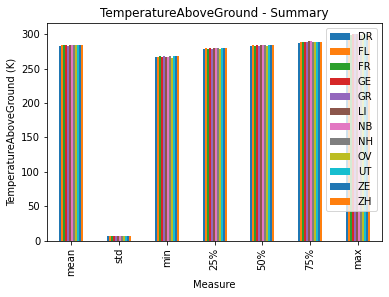

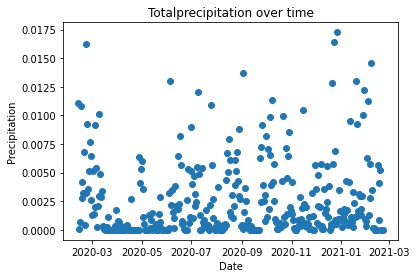

In [19]:
### Read in the weather data from a .csv-file 
weather_data = pd.read_csv("../Data/Raw/weather/weather.csv", sep=",")

### Print the dimensions of the data as well as all the fields 
print(f"Length of the data: {len(weather_data)}")
print(f"Fields: {len(weather_data.columns)}")
for i in weather_data.columns:
    print(i)

### Check for missing values in the data set 
weather_data.isnull().values.any()

### Add two new columns based on the iso3166-2 column to 
### create a "country"-column and a "region"-column
weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)


### Filter the data based on the country
nl_data = weather_data[weather_data["country"] == "NL"]

### Group data based on region and for each region calculate 
### min, max, mean and median for each numeric column. 
### For each of the regions, write these to a file named after the region
agg_data = nl_data.groupby("region")
for i in agg_data:
    with open(f"{i[0]}_summary.txt","w") as outfile:
        outfile.write(str(i[1].describe()))

### Plot TemperatureAboveGround 
tmp_df = pd.DataFrame()
for i in agg_data:
    tmp = i[1].describe()
    tmp_df[i[0]] = tmp["TemperatureAboveGround"][1:]

tmp_df.plot(kind="bar")
plt.title("TemperatureAboveGround - Summary")
plt.ylabel("TemperatureAboveGround (K)")
plt.xlabel("Measure")
plt.show()

### Group data based on date and calculate means of all 
### numerical columns 
agg_data = nl_data.groupby("date")
mean_data = {}
index = []
for i in agg_data:
    index.append(i[0])
    tmp = i[1].describe()
    for j in tmp:
        if j in mean_data.keys():
            mean_data[j].append(tmp[j]["mean"])
        else:
            mean_data[j] = [tmp[j]["mean"]]
new_data = pd.DataFrame(mean_data,index=index)
new_data.index = pd.to_datetime(new_data.index)

### Plot TemperatureAboveGround v. time 
plt.plot_date(new_data.index, new_data["Totalprecipitation"],xdate=True)
plt.title("Totalprecipitation over time")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.savefig(fname="../Reports/Figures/precipitation.png")


# Exercise 2

In [6]:
# file paths
nl_coronadata = "../Data/Raw/corona/nl_corona.csv"
nl_metadata = "../Data/Raw/metadata/nl_metadata.json"
nl_geojson = "../Data/Raw/shapefiles/nl.geojson"

## loading corona data, metadata, and geojson data
# corona_df contains corona data
corona_df = pd.read_csv(nl_coronadata, sep = "\t")

# country_metadata contians metadatasuch as region, iso code, etc.
with open(nl_metadata, "r") as f:
    country_metadata = json.load(f)

# geojson contains coordinates for projection
with open(nl_geojson, "r") as f:
    geojson = json.load(f)

In [7]:
## creating a map instance
# location --> determines where the map will be positioned
# zoom_start --> adjusts default zoom level on map
# crs --> a set of functions that allows for coordinate transformations (?)

m = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")
m

In [8]:
## creating a data frame grouped by region to find cumulative cases per region
covid_region_map = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df["iso3166-2"] = corona_df["region_code"].map(covid_region_map)

# finding cumulative cases per region
corona_df_by_region = corona_df.groupby(by = "iso3166-2")["hospitalized_addition"].sum().reset_index()

# adding population to data frame
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["population"] = corona_df_by_region["iso3166-2"].map(population_map)

# adding cases per population to data frame
cases_per_population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: corona_df_by_region["hospitalized_addition"][i]/corona_df_by_region["population"][i] for i in range(len(country_metadata["country_metadata"]))}
corona_df_by_region["cases_per_population"] = corona_df_by_region["iso3166-2"].map(cases_per_population_map)

corona_df_by_region

,iso3166-2,hospitalized_addition,population,cases_per_population
0,NL-DR,363.0,493657,0.000735
1,NL-FL,519.0,422979,0.001227
2,NL-FR,349.0,649944,0.000537
3,NL-GE,2510.0,2086142,0.001203
4,NL-GR,279.0,586061,0.000476
5,NL-LI,2191.0,1117164,0.001961
6,NL-NB,4207.0,2563432,0.001641
7,NL-NH,3662.0,2879611,0.001272
8,NL-OV,1125.0,1162500,0.000968
9,NL-UT,1964.0,1354979,0.001449


In [9]:
## choropleth of cases per region

m_cases = folium.Map(location = [52, 5], zoom_start = 7, crs = "EPSG3857")

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases",
    data = corona_df_by_region,
    columns = ["iso3166-2", "hospitalized_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "Hospitalized",
).add_to(m_cases)

folium.LayerControl().add_to(m_cases)

m_cases

In [10]:
## choropleth of population per region

m_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_population)

m_population

In [16]:
## choropleth of cases per population of respective region

m_cases_per_population = folium.Map(location = [52, 5], zoom_start = 7)

folium.Choropleth(
    geo_data = nl_geojson,
    name = "cases per population",
    data = corona_df_by_region,
    columns = ["iso3166-2", "cases_per_population"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(m_cases_per_population)
m_cases_per_population

# Exercise 3

In [ ]:
## cleaning corona data
# how many rows are we losing during the filtering of data?
rows_lost = nl_data.shape[0] - corona_df.shape[0]
rows_lost

merged = nl_data.merge(corona_df, on = ["date", "iso3166-2"])

#check if there are any NA values
#merged.isna().any()

merged = merged.dropna()
#losing more rows after dropping NaN values
#nl_data

for var in merged.columns[2:9]:
    print(var)
    merged[var] = merged[var].astype('float')
merged['hospitalized_addition'] = merged['hospitalized_addition'].astype('float')
print(merged.dtypes)
merged.replace([np.inf,-np.inf],np.nan,inplace=True)
merged.dropna(inplace=True)
merged.isna().any()
merged.isin([np.inf,-np.inf]).values.sum()

v2 = merged.columns[2:9] 

corr_pearson = {}
corr_spearman = {}
corr_pearson_log = {}

#calculating the pearson correlation along with p-value
for var in v2:
    corr_pearson[var] = pearsonr(merged["hospitalized_addition"], merged[var])
#calculating the spearman correlation along with p-value
for var in v2:
    corr_spearman[var] = spearmanr(merged["hospitalized_addition"], merged[var])
#calculating the log-log pearson correlation along with p-value
#doesn't work :(

merged['log_hospital'] = np.log(merged['hospitalized_addition'])
new_merged = merged
new_merged.replace([np.inf,-np.inf],np.nan,inplace=True)
new_merged.dropna(inplace=True)
new_merged.isna().any()
for var in v2:
    new_merged = merged
    new_merged[f"log_{var}"] = np.log(new_merged[var])
    new_merged.replace([np.inf,-np.inf],np.nan,inplace=True)
    new_merged.dropna(inplace=True)
    new_merged.isna().any()
     
    corr_pearson_log[var] = pearsonr(new_merged['log_hospital'], new_merged[f"log_{var}"])

pvals = [corr_pearson[i][0] for i in corr_pearson]
pvals.extend([corr_spearman[i][0] for i in corr_spearman])
pvals.extend([corr_pearson_log[i][0] for i in corr_pearson_log])
print(pvals)
b_results, b_p_adjusted, _, b_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="bonferroni")
print(b_p_adjusted.tolist())
print(b_results.tolist())
h_results, h_p_adjusted, _, h_alpha_adjusted = stats.multitest.multipletests(pvals,alpha=0.05,method="holm")
print(h_p_adjusted.tolist())
print(h_results.tolist())

RelativeHumiditySurface
SolarRadiation
Surfacepressure
TemperatureAboveGround
Totalprecipitation
UVIndex
WindSpeed
date                        object
iso3166-2                   object
RelativeHumiditySurface    float64
SolarRadiation             float64
Surfacepressure            float64
TemperatureAboveGround     float64
Totalprecipitation         float64
UVIndex                    float64
WindSpeed                  float64
country                     object
region                      object
region_name                 object
region_code                  int64
deceased_addition          float64
confirmed_addition         float64
hospitalized_addition      float64
deceased_cumulative        float64
confirmed_cumulative         int64
hospitalized_cumulative    float64
dtype: object
[-0.12630708365813148, 0.008996045710151265, 0.098688329713463, -0.21267134372043706, -0.06700045201228025, -0.16276411285519654, 0.053448008575361694, 0.1220506141047999, -0.24340132796520916, 0.0245426588

/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exercise 4

In [ ]:
#Mapping covid region code to iso31662_code
rm = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_df["region"] = corona_df["region_code"].map(rm)

#Mapping iso 31662_code to population
pm = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_df["population"] = corona_df["region_name"].map(pm)

#Adding a column 'cases_pc' which shows the number of added hospitalizations relative to the population
corona_df["cases_pc"] = corona_df["hospitalized_addition"] / corona_df["population"]


df = corona_df.merge(nl_data, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
df = df.drop(["region_code", "region_y"], axis = 1)
#Dropping some more of the irrelevant variables
df = df.dropna()
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df.dropna(inplace=True)
df.isna().any()
df.isin([np.inf,-np.inf]).values.sum()
df

df = sm.add_constant(df)

#Creating list with all column names and adding a column called 'const' for the constant that was just added to the dataframe
v = []
for i in nl_data.columns:
    v.append(i)
v = v[2:-2]

v.append("const")
print(v)


#fitting the model on different dependent variables
est = sm.OLS(df["hospitalized_addition"], df[v], hasconst = True).fit()
print(est.summary())

est = sm.OLS(np.where(df["hospitalized_addition"] > 1.0e-10, np.log(df["hospitalized_addition"]), -10), df[v], hasconst = True).fit()
print(est.summary())

est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit()
print(est.summary())

regions = ["const",]

for region in set(df["iso3166-2_x"]):
    if region != "DK-81":
        df[region] = (df["iso3166-2_x"] == region).astype(int)
        regions.append(region)
        v.append(region)


est = sm.OLS(np.log(df["cases_pc"] + 1), df[regions], hasconst = True).fit()
print(est.summary())

est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit()
print(est.summary())

est = sm.OLS(np.log(df["cases_pc"] + 1), df[v], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": df["iso3166-2_x"]}, use_t = True)
print(est.summary())

est = sm.OLS(df["Totalprecipitation"], df[v], hasconst = True).fit()
print(est.summary())

# exercises 05

#Assigning the stringency spreadsheet values to variables

stringency = "../Data/Raw/Stringency_Index/stringency.csv"

str_data = pd.read_csv(stringency, sep = ",")
str_data

nl_str = str_data[str_data["CountryName"] == "Netherlands"]

nl_str['Date_formatted']=nl_str['Date']

nl_str['Date_formatted']=nl_str['Date_formatted'].apply(str)

nl_str['Date_formatted'] = nl_str.Date_formatted.apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
nl_str

df

['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation', 'UVIndex', 'WindSpeed', 'const']
                              OLS Regression Results                             
Dep. Variable:     hospitalized_addition   R-squared:                       0.137
Model:                               OLS   Adj. R-squared:                  0.135
Method:                    Least Squares   F-statistic:                     70.15
Date:                   Wed, 02 Mar 2022   Prob (F-statistic):           2.12e-94
Time:                           10:54:13   Log-Likelihood:                -10758.
No. Observations:                   3105   AIC:                         2.153e+04
Df Residuals:                       3097   BIC:                         2.158e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                              coef

/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/Users/issam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,5,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-12-5ed3916b26c4>:75: SettingWithCopyWarning: 
A value is trying to be set on a co

,const,date,region_name,deceased_addition,confirmed_addition,hospitalized_addition,deceased_cumulative,confirmed_cumulative,hospitalized_cumulative,iso3166-2_x,...,country,NL-DR,NL-FR,NL-LI,NL-GE,NL-FL,NL-OV,NL-UT,NL-ZE,NL-GR
192,1.0,2020-03-14,Drenthe,0.0,2.0,0.0,0.0,15,0.0,NL-DR,...,NL,1,0,0,0,0,0,0,0,0
193,1.0,2020-03-14,Flevoland,0.0,7.0,0.0,0.0,14,3.0,NL-FL,...,NL,0,0,0,0,1,0,0,0,0
194,1.0,2020-03-14,Friesland,0.0,1.0,0.0,0.0,8,1.0,NL-FR,...,NL,0,1,0,0,0,0,0,0,0
195,1.0,2020-03-14,Gelderland,1.0,12.0,5.0,1.0,76,14.0,NL-GE,...,NL,0,0,0,1,0,0,0,0,0
196,1.0,2020-03-14,Groningen,0.0,0.0,0.0,0.0,4,1.0,NL-GR,...,NL,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,1.0,2021-02-21,Groningen,0.0,190.0,1.0,171.0,21636,252.0,NL-GR,...,NL,0,0,0,0,0,0,0,0,1
4325,1.0,2021-02-21,Limburg,2.0,389.0,1.0,1399.0,69621,2204.0,NL-LI,...,NL,0,0,1,0,0,0,0,0,0
4328,1.0,2021-02-21,Overijssel,0.0,172.0,2.0,1017.0,74162,1123.0,NL-OV,...,NL,0,0,0,0,0,1,0,0,0
4329,1.0,2021-02-21,Utrecht,3.0,324.0,5.0,1110.0,84158,1967.0,NL-UT,...,NL,0,0,0,0,0,0,1,0,0


In [ ]:
def merge_data(attr_file): 
    with open(attr_file, "r") as infile:
        attributes = json.load(infile)
    weather_data = pd.read_csv(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Weather"]}', sep=",")
    if weather_data.isnull().values.any(): 
        return "Missing data"
    weather_data[["country","region"]]= weather_data["iso3166-2"].str.split("-",expand=True)
    weather_data = weather_data[weather_data["country"] == attributes["Country"]]
    corona_data = pd.read_csv(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Corona"]}', sep="\t")
    with open(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Metadata"]}') as f:
        country_metadata = json.load(f)
    with open(f'{attributes["Files"]["Base_path"]}{attributes["Files"]["Shapefile"]}') as f: 
        geojson = json.load(f)
    covid_region_map = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
    corona_data["iso3166-2"] = corona_data["region_code"].map(covid_region_map)
    for i in attributes["Replacements"]:
        corona_data["region_name"] = corona_data["region_name"].str.replace(i,attributes["Replacements"][i])
    merged = weather_data.merge(corona_data, on = attributes["Merge"])
    for column in merged.columns: 
        try: 
            merged[column] = merged[column].astype("float")
        except ValueError:
            try: 
                merged[column] = pd.to_datetime(merged[column])
            except ValueError:
                pass 
    merged.replace([np.inf,-np.inf],np.nan,inplace=True)
    merged.dropna(inplace=True)
    
    return merged

In [ ]:
corona_and_weather = merge_data("../Scripts/attributes.json")
nl_metadata = "../Data/Raw/metadata/nl_metadata.json"
nl_geojson = "../Data/Raw/shapefiles/nl.geojson"

with open(nl_metadata, "r") as f:
    country_metadata = json.load(f)

with open(nl_geojson, "r") as f:
    geojson = json.load(f)

rm = {int(country_metadata["country_metadata"][i]["covid_region_code"]): country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}
corona_and_weather["region"] = corona_and_weather["region_code"].map(rm)

pm = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: country_metadata["country_metadata"][i]["population"]for i in range(len(country_metadata["country_metadata"]))}
corona_and_weather["population"] = corona_and_weather["region_name"].map(pm)

corona_and_weather["cases_pc"] = corona_and_weather["hospitalized_addition"] / corona_and_weather["population"]

corona_and_weather = corona_and_weather.dropna()
corona_and_weather.replace([np.inf,-np.inf],np.nan,inplace=True)
corona_and_weather.dropna(inplace=True)
corona_and_weather.isna().any()
corona_and_weather.isin([np.inf,-np.inf]).values.sum()
corona_and_weather

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,country,...,region_name,region_code,deceased_addition,confirmed_addition,hospitalized_addition,deceased_cumulative,confirmed_cumulative,hospitalized_cumulative,population,cases_pc
192,2020-03-14,NL-DR,76.175131,5.677015e+06,2.444319e+06,278.645045,0.000246,10.722513,3.870691,NL,...,Drenthe,22.0,0.0,2.0,0.0,0.0,15.0,0.0,493657,0.000000
193,2020-03-14,NL-FL,80.302209,7.426985e+06,2.443688e+06,279.671005,0.000252,9.391304,5.326425,NL,...,Flevoland,24.0,0.0,7.0,0.0,0.0,14.0,3.0,422979,0.000000
194,2020-03-14,NL-FR,77.900978,6.994390e+06,2.444151e+06,279.227731,0.000179,10.532446,5.612008,NL,...,Friesland,21.0,0.0,1.0,0.0,0.0,8.0,1.0,649944,0.000000
195,2020-03-14,NL-GE,77.892281,7.956310e+06,2.441177e+06,279.821025,0.000212,10.868673,3.875319,NL,...,Gelderland,25.0,1.0,12.0,5.0,1.0,76.0,14.0,2086142,0.000002
196,2020-03-14,NL-GR,74.633632,5.360761e+06,2.446000e+06,278.622180,0.000100,10.408840,4.368198,NL,...,Groningen,20.0,0.0,0.0,0.0,0.0,4.0,1.0,586061,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,2021-02-21,NL-NH,75.253727,5.696371e+06,2.429628e+06,283.445914,0.000000,5.766284,4.694117,NL,...,North Holland,27.0,2.0,959.0,11.0,2200.0,179755.0,3654.0,2879611,0.000004
4328,2021-02-21,NL-OV,69.729526,6.547145e+06,2.428964e+06,284.413133,0.000000,5.921844,3.537233,NL,...,Overijssel,23.0,0.0,172.0,2.0,1017.0,74162.0,1123.0,1162500,0.000002
4329,2021-02-21,NL-UT,70.287774,6.386869e+06,2.429348e+06,284.654022,0.000000,5.903930,3.833734,NL,...,Utrecht,26.0,3.0,324.0,5.0,1110.0,84158.0,1967.0,1354979,0.000004
4330,2021-02-21,NL-ZE,67.850837,6.807321e+06,2.428021e+06,284.711623,0.000000,5.975684,4.871302,NL,...,Zeeland,29.0,0.0,79.0,0.0,170.0,15910.0,455.0,383519,0.000000


In [ ]:
corona_and_weather.dtypes

date                       datetime64[ns]
iso3166-2                          object
RelativeHumiditySurface           float64
SolarRadiation                    float64
Surfacepressure                   float64
TemperatureAboveGround            float64
Totalprecipitation                float64
UVIndex                           float64
WindSpeed                         float64
country                            object
region                             object
region_name                        object
region_code                       float64
deceased_addition                 float64
confirmed_addition                float64
hospitalized_addition             float64
deceased_cumulative               float64
confirmed_cumulative              float64
hospitalized_cumulative           float64
population                          int64
cases_pc                          float64
dtype: object

# Exercise 5

In [ ]:
stringency = "../Data/Raw/Stringency_Index/stringency.csv"

str_data = pd.read_csv(stringency, sep = ",")
str_data = str_data[1:]
nl_str = str_data[str_data["CountryCode"] == "NLD"]

nl_str["date"] = pd.to_datetime(nl_str.Date.apply(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8]))


/home/kofod/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3,5,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_22671/1654665821.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nl_str["date"] = pd.to_datetime(nl_str.Date.apply(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8]))


In [ ]:
merge_df = corona_and_weather.merge(nl_str,on=["date"])
merge_df = sm.add_constant(merge_df)
weather = corona_and_weather[["RelativeHumiditySurface",
                            "SolarRadiation",
                            "Surfacepressure",
                            "TemperatureAboveGround",
                            "Totalprecipitation",
                            "UVIndex",
                            "WindSpeed"]]
corona = corona_and_weather["cases_pc"]

/home/kofod/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in reduce
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
weather_vars = ["RelativeHumiditySurface",
                            "SolarRadiation",
                            "Surfacepressure",
                            "TemperatureAboveGround",
                            "Totalprecipitation",
                            "UVIndex",
                            "WindSpeed",
                            "const"]
regions = ["const",]


In [ ]:
regr = linear_model.LinearRegression()
regr.fit(weather,corona)
print(regr.coef_)



[-1.97259605e-07  2.14498641e-13  7.19676664e-12 -1.45907582e-07
  1.33030347e-04 -2.45588924e-07 -1.71165884e-07]


In [ ]:
merge_df["cases_pc"]

0       0.000000
1       0.000000
2       0.000000
3       0.000002
4       0.000000
          ...   
4135    0.000004
4136    0.000002
4137    0.000004
4138    0.000000
4139    0.000004
Name: cases_pc, Length: 4140, dtype: float64

In [ ]:
merge_df.drop("Date",inplace=True,axis=1)
    

In [ ]:
columns = list(merge_df.columns)[2:]

for i in range(18): 
    columns.pop(7)
columns = columns[:49]
columns.append("const")

merge_df["const"] = [1]*len(merge_df)
columns.pop(41)
columns.pop(41)
print(merge_df['const'])


0       1
1       1
2       1
3       1
4       1
       ..
4135    1
4136    1
4137    1
4138    1
4139    1
Name: const, Length: 4140, dtype: int64


In [ ]:
tmp = merge_df[columns]
tmp.replace(np.nan,0,inplace=True)
for i in tmp.dtypes:
    print(i)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int64


/home/kofod/.local/lib/python3.9/site-packages/pandas/core/frame.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [ ]:
tmp_two = np.asarray(merge_df["cases_pc"])


In [ ]:
est = sm.OLS(tmp_two, tmp, hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": merge_df["iso3166-2"]}, use_t = True)
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                 3.227e+09
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           8.12e-51
Time:                        13:00:43   Log-Likelihood:                 43708.
No. Observations:                4140   AIC:                        -8.736e+04
Df Residuals:                    4110   BIC:                        -8.717e+04
Df Model:                          29                                         
Covariance Type:              cluster                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 15
  warnings.warn('covariance of constraints does not have full '


In [ ]:
regr = linear_model.LinearRegression()
regr.fit(tmp,tmp_two)
coef_list = list(regr.coef_)
for i in range(len(columns)):
    print(f"{columns[i]} - {coef_list[i]}")

RelativeHumiditySurface - -1.1431584059305806e-07
SolarRadiation - 1.7337695786941807e-13
Surfacepressure - 3.6223221144697245e-12
TemperatureAboveGround - -1.5557525020273595e-07
Totalprecipitation - 1.907185912297377e-06
UVIndex - -3.7193558318390065e-07
WindSpeed - -1.0377658078815683e-07
C1_Flag - 9.416470972452911e-15
C2_Workplace closing - 8.543301247274753e-07
C2_Flag - -3.2953552115132538e-18
C3_Cancel public events - 9.028163646823833e-07
C3_Flag - 1.1280823403994778e-06
C4_Restrictions on gatherings - -2.714987656662192e-06
C4_Flag - 7.157428404298838e-20
C5_Close public transport - 1.4307111699476502e-06
C5_Flag - 1.4307111699466303e-06
C6_Stay at home requirements - 3.789017457579329e-06
C6_Flag - 6.776263578034403e-20
C7_Restrictions on internal movement - -3.845249699954067e-08
C7_Flag - -3.845249700004075e-08
C8_International travel controls - 9.783230540787169e-20
E1_Income support - 2.2616542336512512e-06
E1_Flag - 1.083143062971807e-06
E2_Debt/contract relief - 8.9751